# 0. Configuration

In [1]:
# KION DATA
INTERACTIONS_PATH = 'https://drive.google.com/file/d/1MomVjEwY2tPJ845zuHeTPt1l53GX2UKd/view?usp=share_link'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/1XGLUhHpwr0NxU7T4vYNRyaqwSK5HU3N4/view?usp=share_link'
USERS_DATA_PATH = 'https://drive.google.com/file/d/1MCTl6hlhFYer1BTwjzIBfdBZdDS_mK8e/view?usp=share_link'

# 1. Modules and functions

In [2]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

/Users/s.khalilbekov/Desktop/private/rekko_handbook/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LightFM was compiled without OpenMP support. Only a single thread will be used.


## 1. 1. Helper functions to avoid copy paste

In [3]:
def read_parquet_from_gdrive(url, engine: str = 'pyarrow'):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_parquet(file_path, engine = engine)

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion:

In [4]:
# interactions data
interactions = read_parquet_from_gdrive(INTERACTIONS_PATH)
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.000
1,699317,1659,2021-05-29,8317,100.000
2,656683,7107,2021-05-09,10,0.000
3,864613,7638,2021-07-05,14483,100.000
4,964868,9506,2021-04-30,6725,100.000


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [5]:
# information about films etc
movies_metadata = read_parquet_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.000,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000,None,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.000,"зарубежные, приключения, комедии",США,NaN,16.000,None,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.000,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.000,None,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [6]:
users_data = read_parquet_from_gdrive(USERS_DATA_PATH)
users_data.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [7]:
# remove redundant data points
interactions_filtered = interactions.loc[interactions['total_dur'] > 300].reset_index(drop = True)

In [8]:
print(interactions.shape, interactions_filtered.shape)

(5476251, 5) (4195689, 5)


In [9]:
interactions_filtered['last_watch_dt'] = pd.to_datetime(interactions_filtered['last_watch_dt'])

In [10]:
# set dates params for filter
MAX_DATE = interactions_filtered['last_watch_dt'].max()
MIN_DATE = interactions_filtered['last_watch_dt'].min()
TEST_INTERVAL_DAYS = 7

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")

min date in filtered interactions: 2021-08-22 00:00:00
max date in filtered interactions:: 2021-03-13 00:00:00


In [11]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

In [12]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['last_watch_dt'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['last_watch_dt'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(3831545, 5) (364144, 5)


In [13]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['last_watch_dt'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

2021-07-17 00:00:00


In [14]:
global_train = global_train.dropna().reset_index(drop = True)

In [15]:
local_train = global_train.loc[global_train['last_watch_dt'] < local_train_thresh]
local_test = global_train.loc[global_train['last_watch_dt'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(2657708, 5) (1173385, 5)


In [16]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(628785, 5)


In [17]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['item_id'].unique())

In [18]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [19]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  572932
user features mapper length -  572932
movies mapper length -  13230
Users movie features mapper length -  13230


In [20]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [22]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

In [23]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'item_id']]))

In [24]:
train_mat

<572932x13230 sparse matrix of type '<class 'numpy.int32'>'
	with 2657708 stored elements in COOrdinate format>

In [25]:
train_mat_weights

<572932x13230 sparse matrix of type '<class 'numpy.float32'>'
	with 2657708 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [26]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [27]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [28]:
# execute training
for _ in tqdm(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

100%|██████████| 20/20 [00:56<00:00,  2.85s/it]


In [34]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][1]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 699317, row number in matrix - 1


In [35]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

13230

In [36]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([ 1.8523349 ,  1.6924132 , -0.96996284, ..., -2.8667026 ,
        -2.6406224 , -2.2773407 ], dtype=float32),
 (13230,))

In [37]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([326, 795,   5,  30, 107, 689,  79,  38, 858, 140])

In [38]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['item_id'], movies_metadata['title']))

In [39]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,326,13915,Вперёд
1,795,3309,"Осторожно, дети!"
2,5,7571,100% волк
3,30,11237,День города
4,107,4880,Афера
5,689,13913,Балто
6,79,4151,Секреты семейной жизни
7,38,3734,Прабабушка легкого поведения
8,858,16346,Дамбо
9,140,7417,Стендап под прикрытием


In [41]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][2]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 864613, row number in matrix - 2


In [42]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape


(array([-0.38525602, -1.991806  ,  2.4157548 , ..., -1.2250773 ,
        -1.7263043 , -1.3586171 ], dtype=float32),
 (13230,))

In [43]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 33,  18,  69, 403,  79,  22, 116,  47, 209,  38])

In [44]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,33,15297,Клиника счастья
1,18,10440,Хрустальный
2,69,9728,Гнев человеческий
3,403,11778,Простые сложности
4,79,4151,Секреты семейной жизни
5,22,13865,Девятаев
6,116,2657,Подслушано
7,47,657,Защитник
8,209,142,Маша
9,38,3734,Прабабушка легкого поведения


In [45]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

151607

In [ ]:
# all_recs = pd.DataFrame()
# for user in tqdm(users_mapping.keys()):
#     row_id = users_mapping[user]
#     pred = lfm_model.predict(
#         row_id,
#         all_cols,
#         num_threads = 4)
#     top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
#     user_recs = pd.DataFrame({'col_id': top_cols})
#     user_recs['item_id'] = user_recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
#     user_recs['title'] = user_recs['item_id'].map(item_name_mapper)

#     all_recs = pd.concat([all_recs, user_recs], ignore_index = True)

In [46]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [47]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [48]:
test_preds['item_id'] = test_preds['user_id'].map(mapper)

In [49]:
test_preds = test_preds.explode('item_id')
test_preds.shape

(1516070, 2)

In [50]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [51]:
test_preds.head()

,user_id,item_id,rank
0,646903,10440,1
0,646903,9728,2
0,646903,16361,3
0,646903,14431,4
0,646903,13865,5


In [52]:
test_preds['item_name'] = test_preds['item_id'].map(item_name_mapper)
test_preds.head()

,user_id,item_id,rank,item_name
0,646903,10440,1,Хрустальный
0,646903,9728,2,Гнев человеческий
0,646903,16361,3,Doom: Аннигиляция
0,646903,14431,4,Приворот. Чёрное венчание
0,646903,13865,5,Девятаев


In [53]:
# sense check for diversity of recommendations
test_preds.item_id.nunique()

1773

## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative venet -- 0 otherwise

In [54]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(79212, 8)

In [55]:
negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(287372, 8)

In [56]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [57]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [58]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [59]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:           user_id       rank   total_dur  watched_pct     target
count  293234.000 293234.000   63506.000    63506.000 293234.000
mean   548539.269      5.307   17065.558       62.273      0.217
std    316737.327      2.882   34060.136       36.801      0.412
min        11.000      1.000     301.000        0.000      0.000
25%    273796.000      3.000    3237.000       25.000      0.000
50%    547971.000      5.000    7223.000       75.000      0.000
75%    823232.750      8.000   19176.500      100.000      0.000
max   1097534.000     10.000 1842484.000      100.000      1.000 
, TEST:           user_id      rank   total_dur  watched_pct    target
count   73350.000 73350.000   15706.000    15706.000 73350.000
mean   546684.141     5.303   17181.947       62.828     0.214
std    316756.442     2.879   35251.137       36.508     0.410
min        53.000     1.000     301.000        0.000     0.000
25%    272425.500     3.000    3330.250       25.000     0.000
50%    547684.000    

In [60]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
USER_FEATURES = ['age', 'income', 'sex', 'kids_flg']
ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating']

In [61]:
# joins user features
cbm_train_set = pd.merge(cbm_train_set, users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_data[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])


In [62]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])


In [63]:
print(cbm_train_set.shape, cbm_test_set.shape)

(293234, 16) (73350, 16)


In [64]:
cbm_train_set.head()

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,921481,9728,4,Гнев человеческий,2021-08-13,7937.000,100.000,1,NaN,NaN,NaN,NaN,film,2021.000,NaN,18.000
1,811938,3734,6,Прабабушка легкого поведения,NaT,NaN,NaN,0,age_55_64,income_20_40,Ж,0.000,film,2021.000,NaN,16.000
2,549140,15297,2,Клиника счастья,2021-07-22,23652.000,100.000,1,age_25_34,income_20_40,М,1.000,series,2021.000,NaN,18.000
3,835715,8636,8,Белый снег,NaT,NaN,NaN,0,age_35_44,income_20_40,М,1.000,film,2021.000,NaN,6.000
4,688021,10440,3,Хрустальный,NaT,NaN,NaN,0,age_45_54,income_40_60,Ж,1.000,series,2021.000,NaN,18.000


In [65]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['age', 'income', 'sex', 'content_type']
DROP_COLS = ['item_name', 'last_watch_dt', 'watched_pct', 'total_dur']

In [66]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(293234, 9) (73350, 9)


In [68]:
# no time dependent feature -- we can leave it with mode
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

## 2.5.2. Train Model

In [69]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [70]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS,
    verbose = False
)

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [71]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

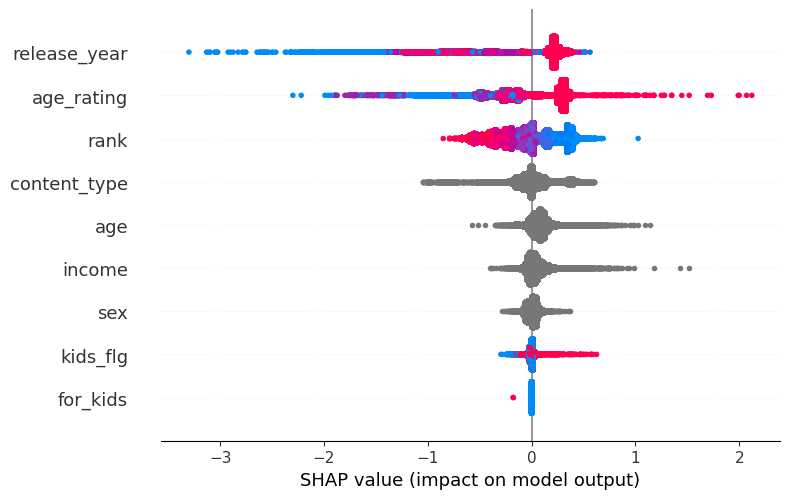

In [72]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [73]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

In [74]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.68


## 2.6. Evaluation on global test

In [75]:
global_test_predictions = pd.DataFrame({
    'user_id': global_test['user_id'].unique()
        }
    )

# only warm start
global_test_predictions = global_test_predictions.loc[global_test_predictions['user_id'].isin(local_train.user_id.unique())]

In [76]:
# set param for number of candidates
top_k = 100

# generate list of watched titles to filter
watched_movies = local_train.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = watched_movies,
    N = top_k,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 10
)

global_test_predictions['item_id'] = global_test_predictions['user_id'].map(mapper)
global_test_predictions = global_test_predictions.explode('item_id').reset_index(drop=True)
global_test_predictions['rank'] = global_test_predictions.groupby('user_id').cumcount() + 1 

In [77]:
# prepare data for reranker
cbm_global_test = pd.merge(global_test_predictions, users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])

cbm_global_test = pd.merge(cbm_global_test, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,203219,10440,1,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000
1,203219,15297,2,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000
2,203219,13865,3,NaN,NaN,NaN,NaN,film,2021.000,NaN,12.000
3,203219,9728,4,NaN,NaN,NaN,NaN,film,2021.000,NaN,18.000
4,203219,4151,5,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000


In [78]:
cbm_global_test = cbm_global_test.fillna(cbm_global_test.mode().iloc[0])

In [99]:
# make predictions
cbm_global_test['cbm_preds'] = cbm_classifier.predict_proba(cbm_global_test[X_train.columns])[:, 1]
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating,cbm_preds
0,203219,10440,1,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000,0.329
1,203219,15297,2,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000,0.307
2,203219,13865,3,age_35_44,income_20_40,М,0.000,film,2021.000,0.000,12.000,0.306
3,203219,9728,4,age_35_44,income_20_40,М,0.000,film,2021.000,0.000,18.000,0.373
4,203219,4151,5,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000,0.229


In [102]:
# set cbm rank
cbm_global_test = cbm_global_test.sort_values(by = ['user_id', 'cbm_preds'], ascending = [True, False])
cbm_global_test['cbm_rank'] = cbm_global_test.groupby('user_id').cumcount() + 1

In [103]:
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating,cbm_preds,cbm_rank
4365401,21,9728,2,age_45_54,income_20_40,Ж,0.000,film,2021.000,0.000,18.000,0.341,1
4365403,21,10440,4,age_45_54,income_20_40,Ж,0.000,series,2021.000,0.000,18.000,0.280,2
4365400,21,13865,1,age_45_54,income_20_40,Ж,0.000,film,2021.000,0.000,12.000,0.269,3
4365405,21,15297,6,age_45_54,income_20_40,Ж,0.000,series,2021.000,0.000,18.000,0.227,4
4365420,21,14703,21,age_45_54,income_20_40,Ж,0.000,film,2021.000,0.000,18.000,0.212,5


Now, let's move on to comparison
- define function to calculate matrix-based metrics;
- create table of metrics for both models

In [104]:
def calc_metrics(df_true, df_pred, k: int = 10, target_col = 'rank'):
    """
    calculates confusion matrix based metrics
    :df_true: pd.DataFrame
    :df_pred: pd.DataFrame
    :k: int, 
    """
    # prepare dataset
    df = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    df = df.sort_values(by = ['user_id', target_col])
    df['users_watch_count'] = df.groupby(level = 'user_id')[target_col].transform(np.size)
    df['cumulative_rank'] = df.groupby(level = 'user_id').cumcount() + 1
    df['cumulative_rank'] = df['cumulative_rank'] / df[target_col]
    
    # params to calculate metrics
    output = {}
    num_of_users = df.index.get_level_values('user_id').nunique()

    # calc metrics
    df[f'hit@{k}'] = df[target_col] <= k
    output[f'Precision@{k}'] = (df[f'hit@{k}'] / k).sum() / num_of_users
    output[f'Recall@{k}'] = (df[f'hit@{k}'] / df['users_watch_count']).sum() / num_of_users
    output[f'MAP@{k}'] = (df["cumulative_rank"] / df["users_watch_count"]).sum() / num_of_users
    print(f'Calculated metrics for top {k}')
    return output

In [107]:
# first-level only - LightFM
lfm_metrics = calc_metrics(global_test, global_test_predictions)
lfm_metrics

Calculated metrics for top 10


{'Precision@10': 0.008529064341606354,
 'Recall@10': 0.04790791086945724,
 'MAP@10': 0.023314840904578304}

In [108]:
# LightFM + ReRanker
full_pipeline_metrics = calc_metrics(global_test, cbm_global_test, target_col = 'cbm_rank')
full_pipeline_metrics

Calculated metrics for top 10


{'Precision@10': 0.009166019487172793,
 'Recall@10': 0.05314362097216618,
 'MAP@10': 0.025169703190213725}

In [128]:
metrics_table = pd.concat(
    [pd.DataFrame([lfm_metrics]),
    pd.DataFrame([full_pipeline_metrics])],
    ignore_index = True
)
metrics_table.index = ['LightFM', 'FullPipeline']

# calc relative diff
metrics_table = metrics_table.append(metrics_table.pct_change().iloc[-1].mul(100).rename('lift_by_ranker, %'))

metrics_table

,Precision@10,Recall@10,MAP@10
LightFM,0.009,0.048,0.023
FullPipeline,0.009,0.053,0.025
"lift_by_ranker, %",7.468,10.929,7.956


Thus, with a few number of features we could signifficantly improve our metrics using reranker. Just imagine how it can be improved if we add more features and fine tune the model

### Source & further readings
- [Kaggle notebook from MTS RecSys course](https://www.kaggle.com/code/sharthz23/implicit-lightfm/notebook)
- [Hybrid Approach](https://github.com/sharthZ23/your-second-recsys/blob/master/lecture_5/tutorial_hybrid_model.ipynb)